# Optimized Sales pred

In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns 
import matplotlib.pyplot as plt

col_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Goals
- outlier analysis
- cross validation
- lagfeatures
- predictions

In [40]:
df = pd.read_csv("archive (2)/PJME_hourly.csv")

In [13]:
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [42]:
df.set_index('Datetime',inplace=True)

In [43]:
df.index = pd.to_datetime(df.index)
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


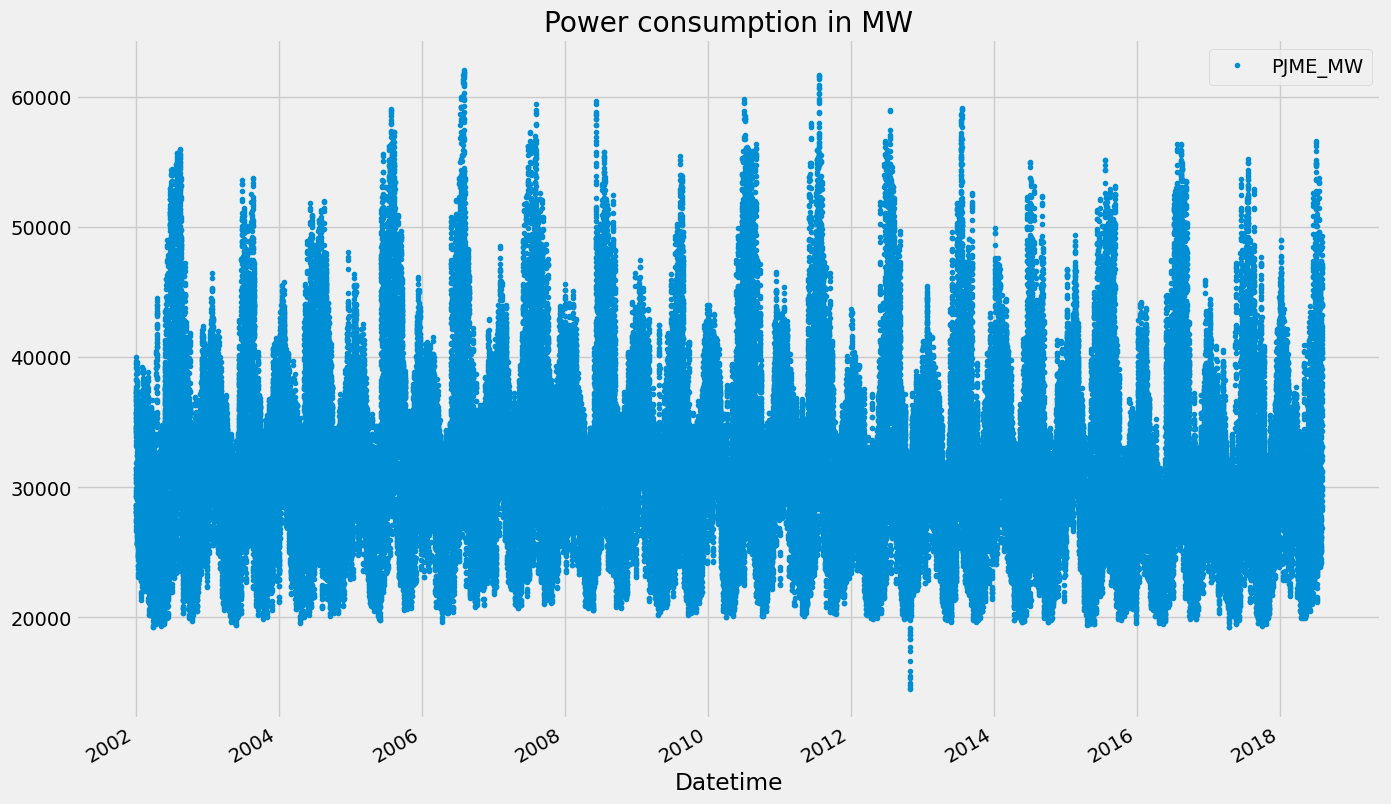

In [44]:
df.plot(style='.',figsize=(15,10),title = "Power consumption in MW")
plt.show()

<Axes: ylabel='Frequency'>

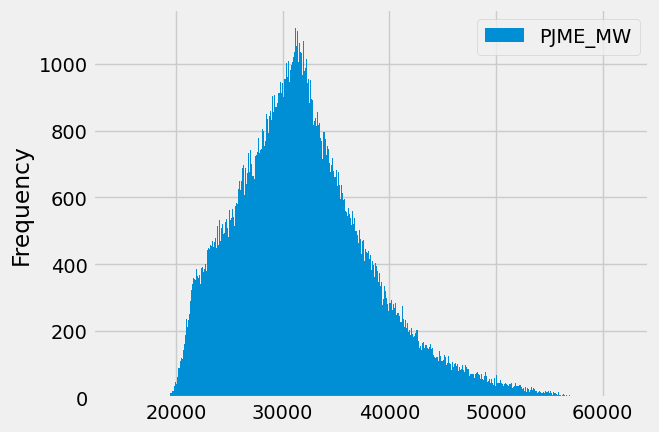

In [45]:
df.plot(kind="hist",bins=500)

<Axes: xlabel='Datetime'>

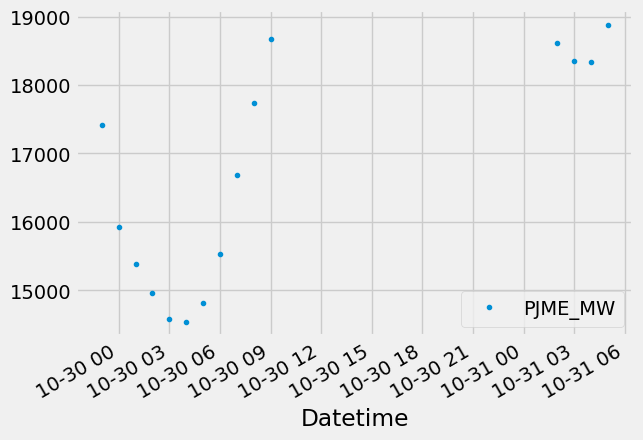

In [34]:
df.query('PJME_MW <19000').plot(style='.')

In [35]:
df = df.query('PJME_MW <19000').copy()

In [38]:
df

,PJME_MW
Datetime,
2012-10-31 02:00:00,18618.0
2012-10-31 03:00:00,18350.0
2012-10-31 04:00:00,18330.0
2012-10-31 05:00:00,18880.0
2012-10-30 01:00:00,15390.0
2012-10-30 02:00:00,14955.0
2012-10-30 03:00:00,14586.0
2012-10-30 04:00:00,14544.0
2012-10-30 05:00:00,14821.0


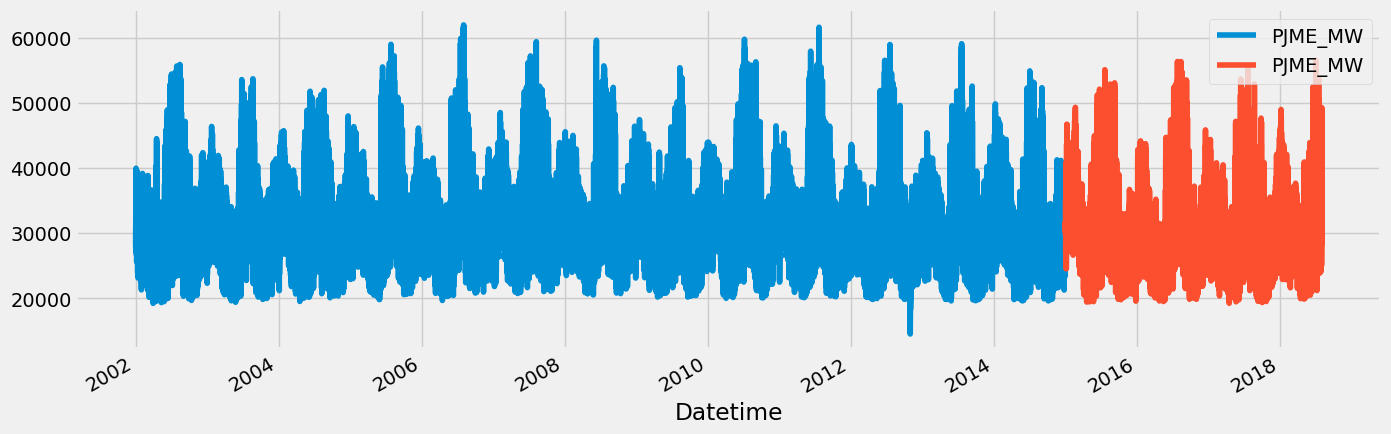

In [46]:
fig,ax = plt.subplots(figsize=(15,5))
df.loc[df.index<'2015-01-01'].plot(ax =ax ,label ="train")
df.loc[df.index>'2015-01-01'].plot(ax=ax,label="test")
plt.show()

# Time series split 

In [37]:
from sklearn.model_selection import TimeSeriesSplit

In [48]:
tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap=24)
df = df.sort_index()

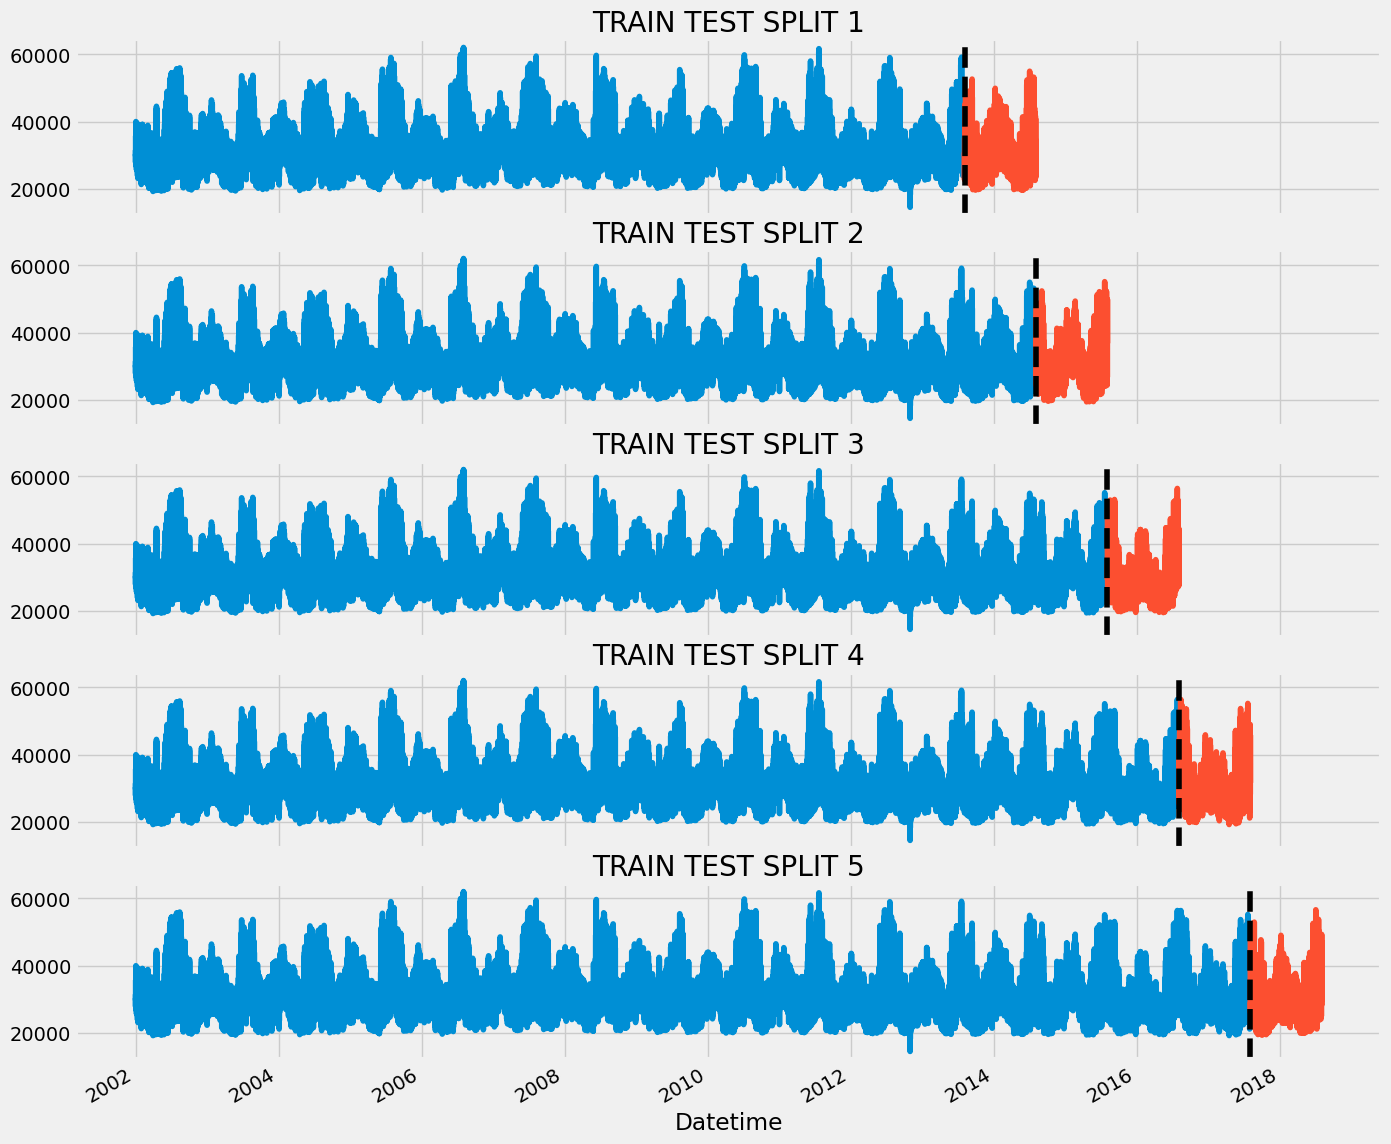

In [66]:
fig,axs = plt.subplots(5,1,figsize = (15,15),sharex=True)
fold= 0

for train_idx,test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    train['PJME_MW'].plot(ax=axs[fold],label="train",title=f"TRAIN TEST SPLIT {fold+1}")
    test['PJME_MW'].plot(ax=axs[fold])
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold+=1
   

In [51]:
train_idx

array([     0,      1,      2, ..., 101539, 101540, 101541])

In [52]:
test_idx

array([101566, 101567, 101568, ..., 110323, 110324, 110325])

# Forecasting horizon
how far into the future you want to predict the values 

In [69]:
def createfeatures(df):
    df = df.copy()
    df['hours']=df.index.hour
    df['dayoftheweek']=df.index.day_of_week
    df['quater']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayoftheyear']=df.index.day_of_year
    df['dayofmonth']=df.index.day
    df['weekofyear']=df.index.isocalendar().week
    return df
df = createfeatures(df)

In [70]:
df

,PJME_MW,hours,dayoftheweek,quater,month,year,dayoftheyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


# lag features 

what are the features x years in the future.

In [73]:
target_map = df['PJME_MW'].to_dict()

In [77]:
def createlags(df):
    df['lag1']=(df.index -pd.Timedelta('364 days')).map(target_map)
    df['lag2']=(df.index -pd.Timedelta('728 days')).map(target_map)
    df['lag3']=(df.index -pd.Timedelta('1092 days')).map(target_map)
    return df

In [78]:
df = createlags(df)

In [93]:
df = df.fillna(0)
df

,PJME_MW,hours,dayoftheweek,quater,month,year,dayoftheyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,0.0,0.0,0.0
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,0.0,0.0,0.0
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,0.0,0.0,0.0
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,0.0,0.0,0.0
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


# Train using cross validation

In [96]:
tss = TimeSeriesSplit(n_splits=5,test_size = 365*24*1,gap=24)
df = df.sort_index()
fold =0
preds =[]
scores =[]

for train_idx,test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    train = createfeatures(train)
    test = createfeatures(test)

    
    features = ['hours', 'dayoftheweek', 'quater', 'month', 'year',
       'dayoftheyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
    target = ['PJME_MW']

    X_train = train[features]
    X_test = test[features]
    y_train = train[target]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5,booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:linear',max_depth=3,learning_rate=0.01)
    reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose =100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

[0]	validation_0-rmse:32730.72700	validation_1-rmse:31954.32539


/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:20:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12541.18405	validation_1-rmse:11804.54843
[200]	validation_0-rmse:5747.24519	validation_1-rmse:5346.53224
[300]	validation_0-rmse:3861.24749	validation_1-rmse:3911.00465
[400]	validation_0-rmse:3422.00560	validation_1-rmse:3771.40953
[477]	validation_0-rmse:3321.81560	validation_1-rmse:3772.10480
[0]	validation_0-rmse:32670.55916	validation_1-rmse:32136.96643


/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12521.14458	validation_1-rmse:12090.67369
[200]	validation_0-rmse:5742.64325	validation_1-rmse:5595.10156
[300]	validation_0-rmse:3882.73790	validation_1-rmse:3879.33474
[400]	validation_0-rmse:3463.76844	validation_1-rmse:3574.02062
[500]	validation_0-rmse:3346.79115	validation_1-rmse:3506.72669
[600]	validation_0-rmse:3288.88318	validation_1-rmse:3472.46092
[700]	validation_0-rmse:3246.12874	validation_1-rmse:3448.05749
[800]	validation_0-rmse:3209.55174	validation_1-rmse:3428.11011
[900]	validation_0-rmse:3182.36279	validation_1-rmse:3415.22284
[999]	validation_0-rmse:3156.40807	validation_1-rmse:3403.40500
[0]	validation_0-rmse:32629.74095	validation_1-rmse:31071.52084


/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:20:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12504.82674	validation_1-rmse:11043.60101
[200]	validation_0-rmse:5740.95126	validation_1-rmse:4782.94661
[300]	validation_0-rmse:3886.91874	validation_1-rmse:3549.61289
[400]	validation_0-rmse:3473.76688	validation_1-rmse:3542.78125
[401]	validation_0-rmse:3471.57385	validation_1-rmse:3544.16472
[0]	validation_0-rmse:32527.11630	validation_1-rmse:31471.80155


/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:20:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12470.29559	validation_1-rmse:11859.83076
[200]	validation_0-rmse:5729.51316	validation_1-rmse:5743.26897
[300]	validation_0-rmse:3883.52550	validation_1-rmse:4350.10194
[400]	validation_0-rmse:3476.39513	validation_1-rmse:4146.43078
[500]	validation_0-rmse:3360.01719	validation_1-rmse:4109.27250
[600]	validation_0-rmse:3303.32478	validation_1-rmse:4081.35570
[700]	validation_0-rmse:3262.79072	validation_1-rmse:4073.62932
[800]	validation_0-rmse:3230.49000	validation_1-rmse:4060.86679
[900]	validation_0-rmse:3204.12967	validation_1-rmse:4054.42879
[999]	validation_0-rmse:3180.20757	validation_1-rmse:4038.80217
[0]	validation_0-rmse:32460.84582	validation_1-rmse:31460.99485


/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:20:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12454.71607	validation_1-rmse:11805.45503
[200]	validation_0-rmse:5742.02325	validation_1-rmse:5534.78697
[300]	validation_0-rmse:3911.59719	validation_1-rmse:4153.86367
[400]	validation_0-rmse:3513.31190	validation_1-rmse:4017.25800
[500]	validation_0-rmse:3402.34660	validation_1-rmse:4002.58310
[551]	validation_0-rmse:3371.21729	validation_1-rmse:4020.74348


In [100]:
print("mean:",np.mean(scores))
print(scores)

mean: 3741.935961109343
[3767.835320180541, 3403.404912730779, 3497.4862401444843, 4038.473226356713, 4002.4801061341955]


# retrain on entire dataset

In [105]:
df = createfeatures(df)
df.columns 
target = ['PJME_MW']
features = ['hours', 'dayoftheweek', 'quater', 'month', 'year',
       'dayoftheyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']

X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5,booster='gbtree',
                          n_estimators=500,
                          early_stopping_rounds=50,
                          objective='reg:linear',max_depth=3,learning_rate=0.01)
reg.fit(X_all,y_all,eval_set=[(X_all,y_all)],verbose =100)

[0]	validation_0-rmse:32402.76554


/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:27:02] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12437.20424
[200]	validation_0-rmse:5748.43155
[300]	validation_0-rmse:3944.94837
[400]	validation_0-rmse:3555.46693
[499]	validation_0-rmse:3445.90281


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# future prediction storage

In [106]:
df.tail()

,PJME_MW,hours,dayoftheweek,quater,month,year,dayoftheyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [111]:
future = pd.date_range('2018-08-03','2019-08-01',freq='1h')
df_new = pd.DataFrame(index = future)
df_new

""
2018-08-03 00:00:00
2018-08-03 01:00:00
2018-08-03 02:00:00
2018-08-03 03:00:00
2018-08-03 04:00:00
...
2019-07-31 20:00:00
2019-07-31 21:00:00
2019-07-31 22:00:00
2019-07-31 23:00:00


In [117]:
df_new['isfuture']=True
df['isfuture']=False
df_future = pd.concat([df,df_new])
df_future = createfeatures(df_future)
df_future = createlags(df_future)
df_future

,PJME_MW,hours,dayoftheweek,quater,month,year,dayoftheyear,dayofmonth,weekofyear,lag1,lag2,lag3,isfuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [123]:
future_predict = df_future.query('isfuture').copy()

In [124]:
future_predict

,PJME_MW,hours,dayoftheweek,quater,month,year,dayoftheyear,dayofmonth,weekofyear,lag1,lag2,lag3,isfuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [128]:
future_predict['pred']=reg.predict(future_predict[features])
future_predict

,PJME_MW,hours,dayoftheweek,quater,month,year,dayoftheyear,dayofmonth,weekofyear,lag1,lag2,lag3,isfuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True,31408.675781
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True,28904.791016
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True,27897.652344
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True,26927.685547
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True,26638.087891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True,41838.855469
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True,41118.910156
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True,40160.828125
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True,37840.589844


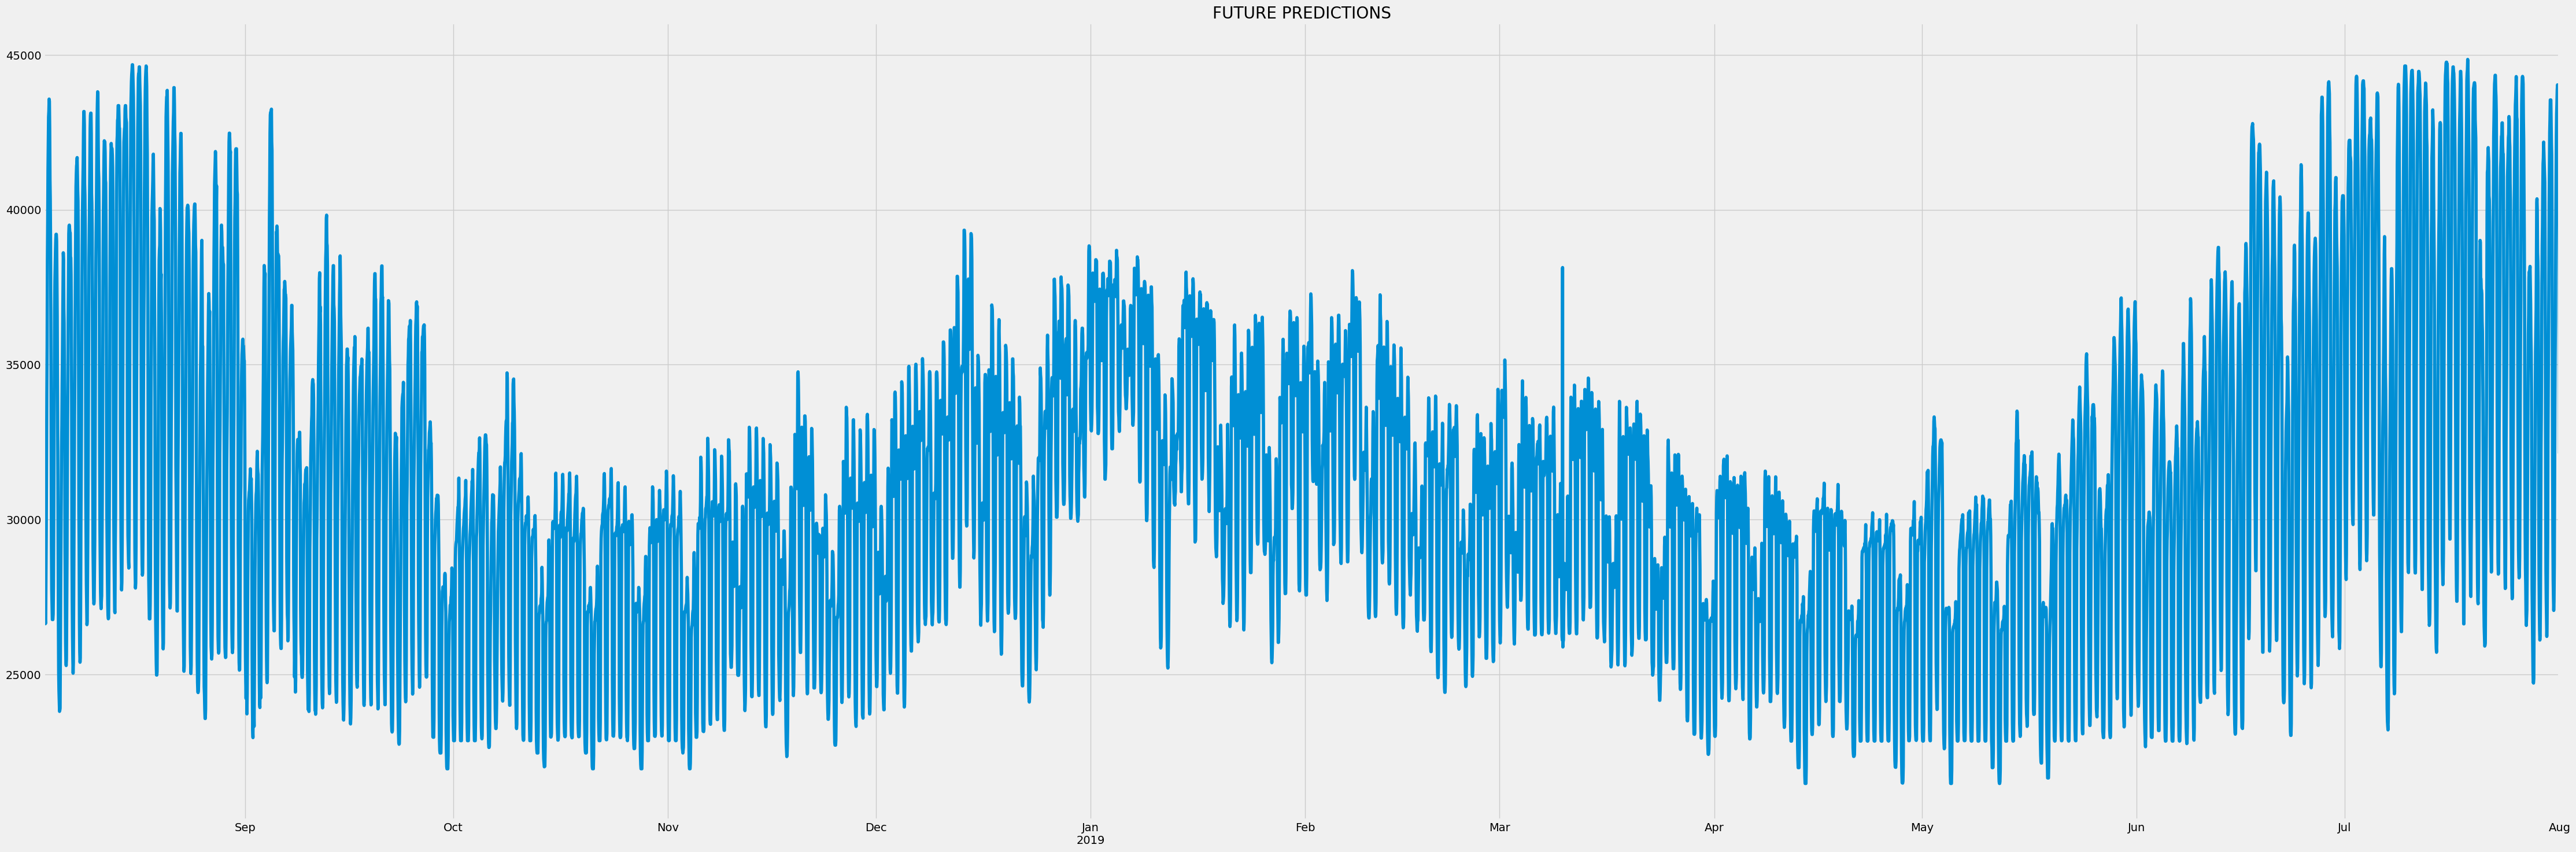

In [138]:
future_predict['pred'].plot(figsize=(50,17),title="FUTURE PREDICTIONS")
plt.show()

# Saving model

In [139]:
reg.save_model('model.json')

/Users/aryansahni/miniforge3/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `learning_rate` as keyword args.
  warnings.warn(msg, FutureWarning)


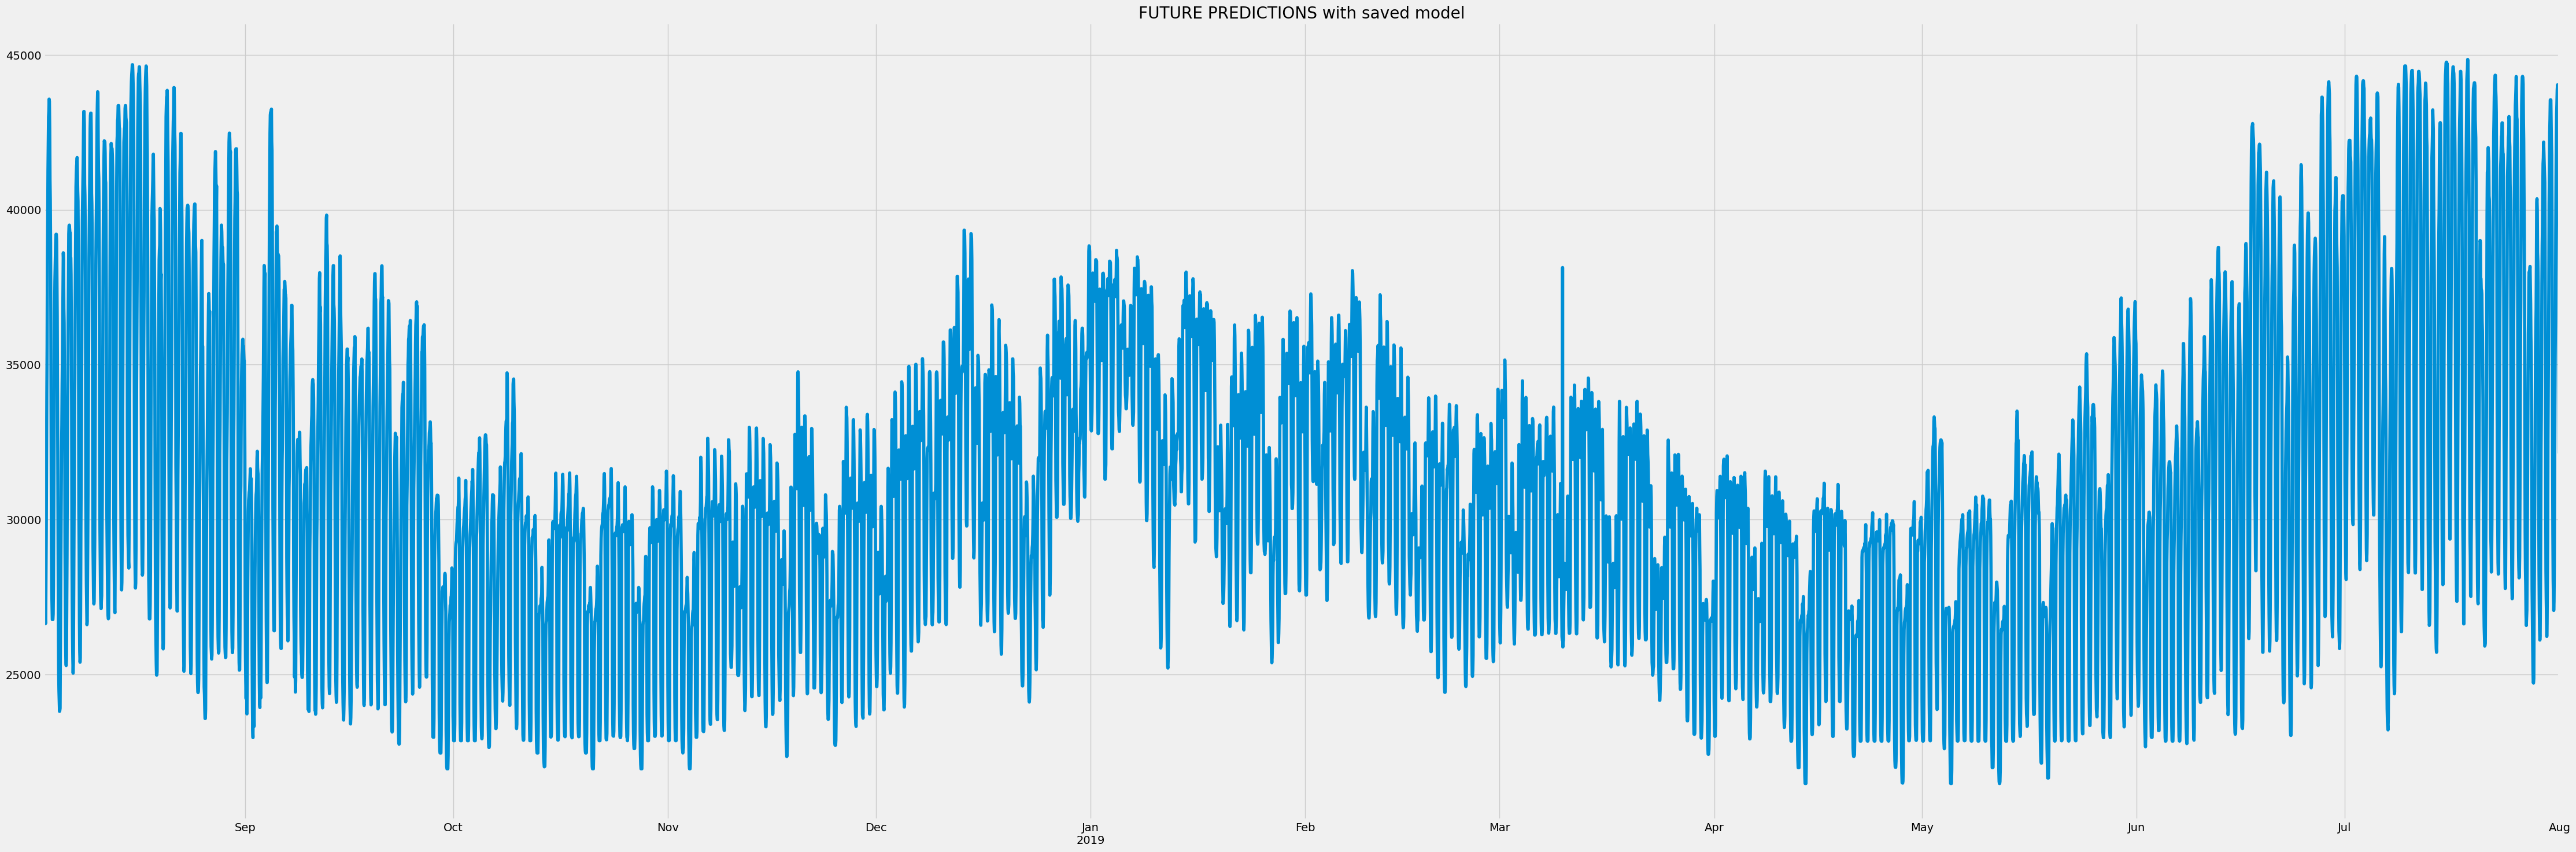

In [142]:
reg_new = xgb.XGBRFRegressor('model.json')
future_predict['pred2']=reg.predict(future_predict[features])
future_predict['pred2'].plot(figsize=(50,17),title="FUTURE PREDICTIONS with saved model")
plt.show()